In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D

In [3]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [4]:
train_data = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/chest_xray/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 64,
    image_size = (256, 256)
)

Found 5245 files belonging to 2 classes.


In [5]:
valid_data = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/chest_xray/val',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 64,
    image_size = (256, 256)
)

Found 17 files belonging to 2 classes.


In [6]:
test_data = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/chest_xray/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 64,
    image_size = (256, 256)
)

Found 624 files belonging to 2 classes.


In [7]:
def process(image, label):
  image = tf.cast(image/255. ,tf.float32)
  return image, label

  train_data=train_data.map(process)
  valid_data=valid_data.map(process)

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


94765736/94765736 [==============================] - 0s 0us/step


In [9]:
base_model.trainable = False

In [10]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Replaces Flatten for global pooling
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)


# TRAINING THE MODEL

In [15]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=test_data,
                    callbacks=[early_stopping])

Epoch 1/10
82/82 [==============================] - 186s 2s/step - loss: 0.4063 - accuracy: 0.8177 - val_loss: 0.3985 - val_accuracy: 0.8029
Epoch 2/10
82/82 [==============================] - 138s 2s/step - loss: 0.2041 - accuracy: 0.9167 - val_loss: 0.3602 - val_accuracy: 0.8462
Epoch 3/10
82/82 [==============================] - 136s 2s/step - loss: 0.1600 - accuracy: 0.9399 - val_loss: 0.5379 - val_accuracy: 0.8109
Epoch 4/10
82/82 [==============================] - 136s 2s/step - loss: 0.1391 - accuracy: 0.9491 - val_loss: 0.4678 - val_accuracy: 0.8381
Epoch 5/10
82/82 [==============================] - 138s 2s/step - loss: 0.1189 - accuracy: 0.9579 - val_loss: 0.5616 - val_accuracy: 0.8189
Epoch 6/10
82/82 [==============================] - 136s 2s/step - loss: 0.1144 - accuracy: 0.9569 - val_loss: 0.5165 - val_accuracy: 0.8333
Epoch 6: early stopping


In [16]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy:', accuracy)

10/10 [==============================] - 15s 1s/step - loss: 0.3602 - accuracy: 0.8462
Test accuracy: 0.8461538553237915


In [17]:
model.save('chest_xray.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
from tensorflow.keras.models import load_model
model = load_model('chest_xray.h5')


In [19]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [20]:
test_img = cv2.imread('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person119_bacteria_565.jpeg')

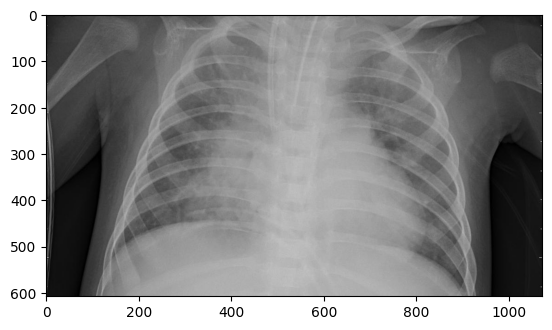

In [21]:
plt.imshow(test_img)

In [22]:
test_img.shape

(608, 1072, 3)

In [23]:
test_img = cv2.resize(test_img, (256, 256))

In [24]:
test_input = test_img.reshape((1, 256, 256, 3))

In [25]:
prediction = model.predict(test_input)

1/1 [==============================] - 1s 954ms/step


In [26]:
prediction[0][0]

0.9988094

In [27]:
threshold = 0.5
if prediction[0][0] > threshold:
  print("Pneumonia")
else:
  print("Normal")

Pneumonia
